# Importar librerias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Descomprimir dataset de kaggle

In [2]:
# Clonar repositorio
!git clone https://github.com/theit0/GreenAI.git

Cloning into 'GreenAI'...
remote: Enumerating objects: 2562, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2562 (delta 0), reused 4 (delta 0), pack-reused 2558 (from 2)
Receiving objects: 100% (2562/2562), 123.02 MiB | 27.40 MiB/s, done.


In [3]:
zip_path = '/content/GreenAI/data/archive.zip'

In [4]:
import zipfile
import os

extract_path = '/content/descomprimido'

# Crear carpeta si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Descomprimido en:", extract_path)

Descomprimido en: /content/descomprimido


# Configuración del dispositivo

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda



## Preparación de Datos
*    Reutilizamos y adaptamos el código de preprocesamiento de la Semana 2
*    Configuración de rutas y parámetros

In [6]:
DATA_PATH = '/content/descomprimido/Garbage classification/Garbage classification/'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# Clases del dataset

In [7]:
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
NUM_CLASSES = len(CLASSES)

print(f"Clases: {CLASSES}")
print(f"Número de clases: {NUM_CLASSES}")

Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Número de clases: 6


In [8]:
class WasteDataset(Dataset):
    """Dataset personalizado para clasificación de residuos"""

    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Cargar rutas de imágenes y etiquetas
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = os.path.join(data_path, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformaciones para entrenamiento (con data augmentation)

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Explicación
* transforms.Resize((IMG_SIZE, IMG_SIZE)):
    > Función: Redimensiona todas las imágenes a 224x224 píxeles  
    > Por qué: Las imágenes vienen en diferentes tamaños, pero la red necesita entrada uniforme  
    > Ejemplo: Una imagen de 1920x1080 se convierte a 224x224

* transforms.RandomHorizontalFlip(p=0.5):

    > Función: Voltea horizontalmente la imagen con 50% de probabilidad  
    > Por qué: Data Augmentation - crea variaciones para evitar overfitting  
    > Ejemplo: Una botella de plástico puede aparecer normal o volteada horizontalmente

* transforms.RandomRotation(degrees=15)

    > Función: Rota la imagen aleatoriamente entre -15° y +15°  
    > Por qué: Los residuos en fotos reales pueden estar en cualquier ángulo  
    > Ejemplo: Una lata puede estar inclinada 10° a la izquierda o derecha

* transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

    > Función: Modifica aleatoriamente:
        - brightness=0.2: Brillo ±20%
        - contrast=0.2: Contraste ±20%
        - saturation=0.2: Saturación ±20%
        - hue=0.1: Matiz ±10%  
    > Por qué: Simula diferentes condiciones de iluminación y cámara  
    > Ejemplo: Una foto puede ser más brillante, más oscura, o con colores más intensos

* transforms.ToTensor()

    > Función: Convierte la imagen PIL a tensor de PyTorch  
    > Cambios:
        - Formato: (H, W, C) → (C, H, W)
        - Valores: [0-255] → [0.0-1.0]  
    > Por qué: PyTorch necesita tensores, no imágenes PIL

* transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    > Función: Normaliza cada canal RGB con media y desviación estándar específicas  
    > Valores: Los de ImageNet (dataset donde se preentrenaron MobileNet y ResNet)
      - Media: [0.485, 0.456, 0.406] (R, G, B)
      - Std: [0.229, 0.224, 0.225] (R, G, B)  
    > Fórmula: pixel_normalizado = (pixel - media) / std  
    > Por qué: Los modelos preentrenados esperan datos en este rango

* Objetivo General:
    Estas transformaciones crean múltiples versiones de cada imagen durante el entrenamiento:
    Imagen Original → [Resize] → [Flip?] → [Rotate] → [ColorJitter] → [ToTensor] → [Normalize]
    Beneficios:

    Previene overfitting: El modelo ve más variaciones
    Mejora generalización: Reconoce residuos en diferentes condiciones
    Aumenta dataset virtual: Una imagen se convierte en miles de variaciones
    Robustez: Funciona con fotos tomadas en diferentes ángulos/iluminación

# Transformaciones para validación (sin augmentation)

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

En la validación se evalúa el modelo tal como esta, no buscando variaciones

# Crear dataset completo y dividir en train/val

In [11]:
full_dataset = WasteDataset(DATA_PATH, transform=train_transform)
dataset_size = len(full_dataset)
print(f"Tamaño total del dataset: {dataset_size}")

Tamaño total del dataset: 2527


# División 80/20 para entrenamiento y validación

In [14]:
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

* se utilizan 80% de los datos para entrenamiento y 20% de los datos para validación siendo el total del dataset de 2527 muestras es un buen porcentaje para seleccionar
* se utiliza manual_seed(42) para siempre obtener la misma generación de datos aleatorios, esto es así para pode controlar si existe un error y el número 42 es un número común utilizado

# Aplicar transformaciones específicas a validación

In [15]:
val_dataset.dataset.transform = val_transform

print(f"Tamaño dataset entrenamiento: {len(train_dataset)}")
print(f"Tamaño dataset validación: {len(val_dataset)}")

Tamaño dataset entrenamiento: 2021
Tamaño dataset validación: 506


# Crear DataLoaders

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Obtener distribución del dataset de entrenamiento

In [17]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
class_counts = Counter(train_labels)

print("Distribución de clases en entrenamiento:")
for class_idx, count in sorted(class_counts.items()):
    print(f"{CLASSES[class_idx]}: {count} imágenes")

Distribución de clases en entrenamiento:
cardboard: 326 imágenes
glass: 396 imágenes
metal: 324 imágenes
paper: 478 imágenes
plastic: 393 imágenes
trash: 104 imágenes


# Calcular pesos para el loss balanceado

In [ ]:
total_samples = sum(class_counts.values())
class_weights = []
for i in range(NUM_CLASSES):
    weight = total_samples / (NUM_CLASSES * class_counts.get(i, 1))
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"\nPesos de clases para loss balanceado: {class_weights}")


Pesos de clases para loss balanceado: [1.0332310838445808, 0.8505892255892256, 1.0396090534979423, 0.7046722454672245, 0.8570822731128075, 3.238782051282051]


#Modelo 1: CNN (SimpleCNN)

In [ ]:
class SimpleCNN(nn.Module):
    """Red neuronal convolucional simple entrenada desde cero"""

    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()

        # Bloque 1: Conv + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # Bloque 2: Conv + ReLU + MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bloque 3: Conv + ReLU + MaxPool
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calcular tamaño después de convoluciones
        # 224x224 -> 112x112 -> 56x56 -> 28x28
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Bloque convolucional 1
        x = self.pool1(self.relu1(self.conv1(x)))

        # Bloque convolucional 2
        x = self.pool2(self.relu2(self.conv2(x)))

        # Bloque convolucional 3
        x = self.pool3(self.relu3(self.conv3(x)))

        # Capas densas
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Instanciar modelo SimpleCNN
model_simple = SimpleCNN(num_classes=NUM_CLASSES).to(device)
print("Modelo SimpleCNN creado:")
print(model_simple)

Modelo SimpleCNN creado:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


## Modelo 2: Fine-tuning con MobileNetV2

In [ ]:
def create_mobilenet_model(num_classes=NUM_CLASSES, pretrained=True):
    """Crear modelo MobileNetV2 con fine-tuning"""
    model = models.mobilenet_v2(pretrained=pretrained)

    # Reemplazar la última capa para nuestro número de clases
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    return model

# Instanciar modelo MobileNetV2
model_mobilenet = create_mobilenet_model(num_classes=NUM_CLASSES).to(device)
print("Modelo MobileNetV2 creado con fine-tuning")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 85.6MB/s]


Modelo MobileNetV2 creado con fine-tuning


## Modelo 3: Fine-tuning con ResNet18

In [ ]:
def create_resnet_model(num_classes=NUM_CLASSES, pretrained=True):
    """Crear modelo ResNet18 con fine-tuning"""
    model = models.resnet18(pretrained=pretrained)

    # Reemplazar la última capa para nuestro número de clases
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

# Instanciar modelo ResNet18
model_resnet = create_resnet_model(num_classes=NUM_CLASSES).to(device)
print("Modelo ResNet18 creado con fine-tuning")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Modelo ResNet18 creado con fine-tuning


## Funciones de Entrenamiento y Evaluación

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    """Función para entrenar un modelo"""

    print(f"\n{'='*50}")
    print(f"Entrenando modelo: {model_name}")
    print(f"{'='*50}")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Fase de entrenamiento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Fase de validación
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val

        # Guardar métricas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    # Cargar el mejor modelo
    model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

 # Evaluar modelo

In [ ]:
def evaluate_model(model, val_loader, class_names):
    """Evaluar modelo y calcular métricas detalladas"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, labels=range(len(class_names))
    )

    # Métricas macro
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': cm,
        'support': support
    }


# Graficar

In [ ]:
def plot_training_history(history, model_name):
    """Graficar historial de entrenamiento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# %%
def plot_confusion_matrix(cm, class_names, model_name):
    """Graficar matriz de confusión"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    plt.show()

# %%
def print_detailed_metrics(metrics, class_names, model_name):
    """Imprimir métricas detalladas"""
    print(f"\n{'='*60}")
    print(f"MÉTRICAS DETALLADAS - {model_name}")
    print(f"{'='*60}")

    print(f"Accuracy General: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"Macro Recall: {metrics['macro_recall']:.4f}")
    print(f"Macro F1-Score: {metrics['macro_f1']:.4f}")

    print(f"\n{'Métricas por Clase':^60}")
    print("-" * 60)
    print(f"{'Clase':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12} {metrics['precision'][i]:<10.4f} {metrics['recall'][i]:<10.4f} "
              f"{metrics['f1'][i]:<10.4f} {metrics['support'][i]:<10}")

    print("-" * 60)

# Entrenamiento de los Modelos

In [ ]:
# Configurar criterio de pérdida con pesos balanceados
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Diccionario para almacenar todos los modelos y resultados
models_results = {}

# Entrenamiento Modelo 1: SimpleCNN




Entrenando modelo: SimpleCNN
Epoch [1/15], Batch [0/64], Loss: 1.7977
Epoch [1/15], Batch [50/64], Loss: 1.5463
Epoch [1/15]:
  Train Loss: 1.7180, Train Acc: 35.03%
  Val Loss: 1.3198, Val Acc: 46.64%
--------------------------------------------------
Epoch [2/15], Batch [0/64], Loss: 1.4811
Epoch [2/15], Batch [50/64], Loss: 1.2471
Epoch [2/15]:
  Train Loss: 1.2862, Train Acc: 49.73%
  Val Loss: 1.2022, Val Acc: 54.35%
--------------------------------------------------
Epoch [3/15], Batch [0/64], Loss: 1.0488
Epoch [3/15], Batch [50/64], Loss: 0.9273
Epoch [3/15]:
  Train Loss: 1.0841, Train Acc: 58.68%
  Val Loss: 1.1618, Val Acc: 59.09%
--------------------------------------------------
Epoch [4/15], Batch [0/64], Loss: 0.8270
Epoch [4/15], Batch [50/64], Loss: 0.9545
Epoch [4/15]:
  Train Loss: 0.9109, Train Acc: 65.81%
  Val Loss: 1.1312, Val Acc: 63.44%
--------------------------------------------------
Epoch [5/15], Batch [0/64], Loss: 0.7445
Epoch [5/15], Batch [50/64], Loss

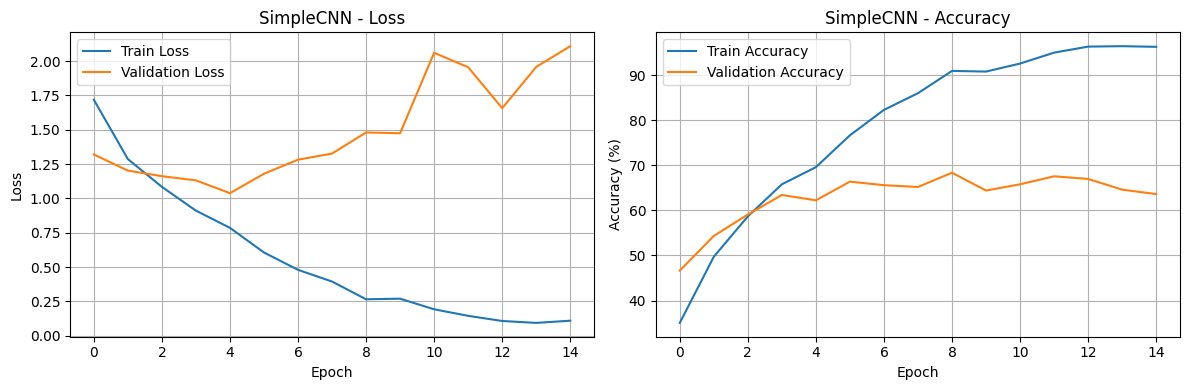


MÉTRICAS DETALLADAS - SimpleCNN
Accuracy General: 0.6364 (63.64%)
Macro Precision: 0.6152
Macro Recall: 0.6342
Macro F1-Score: 0.6193

                     Métricas por Clase                     
------------------------------------------------------------
Clase        Precision  Recall     F1-Score   Support   
------------------------------------------------------------
cardboard    0.6535     0.8571     0.7416     77        
glass        0.6118     0.4952     0.5474     105       
metal        0.5570     0.5116     0.5333     86        
paper        0.7280     0.7845     0.7552     116       
plastic      0.6533     0.5506     0.5976     89        
trash        0.4878     0.6061     0.5405     33        
------------------------------------------------------------


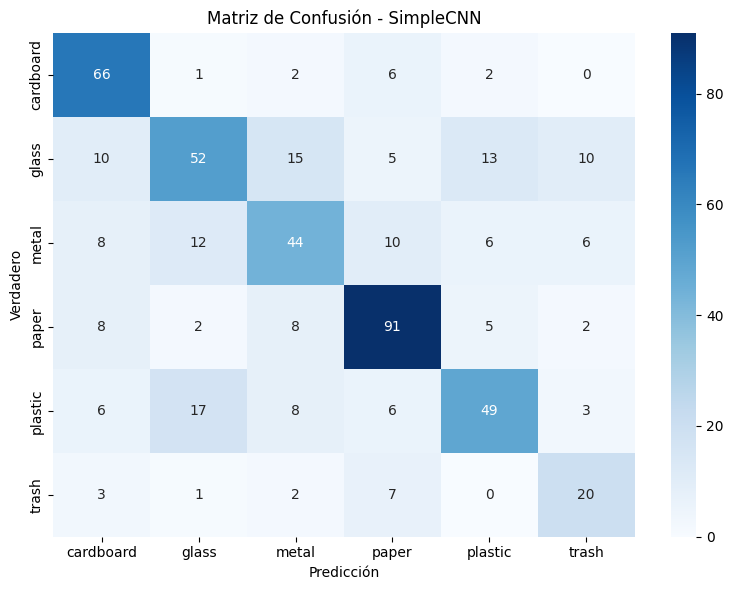

In [ ]:
# Configurar optimizador para SimpleCNN
optimizer_simple = optim.Adam(model_simple.parameters(), lr=LEARNING_RATE)

# Entrenar SimpleCNN
model_simple, history_simple = train_model(
    model_simple, train_loader, val_loader, criterion, optimizer_simple,
    NUM_EPOCHS, "SimpleCNN"
)

# Evaluar SimpleCNN
metrics_simple = evaluate_model(model_simple, val_loader, CLASSES)

# Guardar resultados
models_results['SimpleCNN'] = {
    'model': model_simple,
    'metrics': metrics_simple,
    'history': history_simple
}

# Mostrar resultados
plot_training_history(history_simple, "SimpleCNN")
print_detailed_metrics(metrics_simple, CLASSES, "SimpleCNN")
plot_confusion_matrix(metrics_simple['confusion_matrix'], CLASSES, "SimpleCNN")

# Entrenamiento Modelo 2: MobileNetV2


Entrenando modelo: MobileNetV2
Epoch [1/15], Batch [0/64], Loss: 0.0784
Epoch [1/15], Batch [50/64], Loss: 0.1994
Epoch [1/15]:
  Train Loss: 0.2788, Train Acc: 91.59%
  Val Loss: 1.4135, Val Acc: 69.76%
--------------------------------------------------
Epoch [2/15], Batch [0/64], Loss: 0.4143
Epoch [2/15], Batch [50/64], Loss: 0.1095
Epoch [2/15]:
  Train Loss: 0.1705, Train Acc: 93.57%
  Val Loss: 0.6640, Val Acc: 84.78%
--------------------------------------------------
Epoch [3/15], Batch [0/64], Loss: 0.2210
Epoch [3/15], Batch [50/64], Loss: 0.3546
Epoch [3/15]:
  Train Loss: 0.2234, Train Acc: 93.02%
  Val Loss: 0.8252, Val Acc: 84.39%
--------------------------------------------------
Epoch [4/15], Batch [0/64], Loss: 0.3049
Epoch [4/15], Batch [50/64], Loss: 0.0064
Epoch [4/15]:
  Train Loss: 0.1072, Train Acc: 96.39%
  Val Loss: 0.6768, Val Acc: 87.55%
--------------------------------------------------
Epoch [5/15], Batch [0/64], Loss: 0.0672
Epoch [5/15], Batch [50/64], Lo

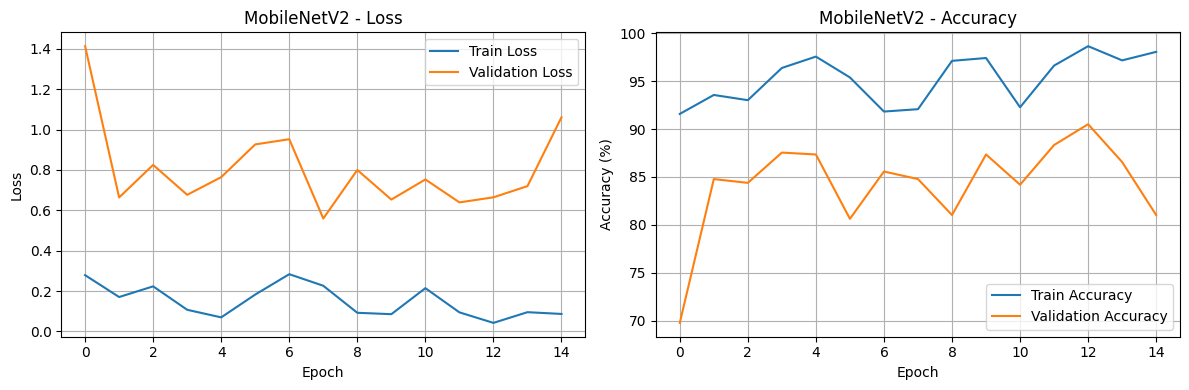


MÉTRICAS DETALLADAS - MobileNetV2
Accuracy General: 0.8103 (81.03%)
Macro Precision: 0.7910
Macro Recall: 0.7962
Macro F1-Score: 0.7840

                     Métricas por Clase                     
------------------------------------------------------------
Clase        Precision  Recall     F1-Score   Support   
------------------------------------------------------------
cardboard    0.9412     0.8312     0.8828     77        
glass        0.8800     0.8381     0.8585     105       
metal        0.7945     0.6744     0.7296     86        
paper        0.8222     0.9569     0.8845     116       
plastic      0.8533     0.7191     0.7805     89        
trash        0.4545     0.7576     0.5682     33        
------------------------------------------------------------


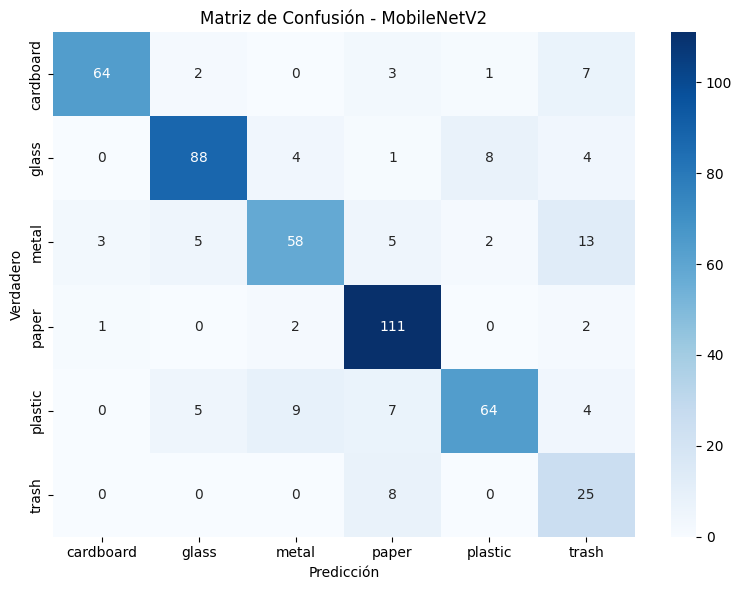

In [ ]:
# Configurar optimizador para MobileNetV2 con diferentes learning rates
# Learning rate menor para capas preentrenadas

optimizer_mobilenet = optim.Adam([
    {'params': model_mobilenet.features.parameters(), 'lr': LEARNING_RATE},
    {'params': model_mobilenet.classifier.parameters(), 'lr': LEARNING_RATE}
])

# Entrenar MobileNetV2

model_mobilenet, history_mobilenet = train_model(
    model_mobilenet, train_loader, val_loader, criterion, optimizer_mobilenet,
    NUM_EPOCHS, "MobileNetV2"
)

# Evaluar MobileNetV2
metrics_mobilenet = evaluate_model(model_mobilenet, val_loader, CLASSES)

# Guardar resultados
models_results['MobileNetV2'] = {
    'model': model_mobilenet,
    'metrics': metrics_mobilenet,
    'history': history_mobilenet
}

# Mostrar resultados
plot_training_history(history_mobilenet, "MobileNetV2")
print_detailed_metrics(metrics_mobilenet, CLASSES, "MobileNetV2")
plot_confusion_matrix(metrics_mobilenet['confusion_matrix'], CLASSES, "MobileNetV2")

# Entrenamiento Modelo 3: ResNet18


Entrenando modelo: ResNet18
Epoch [1/15], Batch [0/64], Loss: 0.0122
Epoch [1/15], Batch [50/64], Loss: 0.0145
Epoch [1/15]:
  Train Loss: 0.0394, Train Acc: 98.61%
  Val Loss: 0.6597, Val Acc: 86.36%
--------------------------------------------------
Epoch [2/15], Batch [0/64], Loss: 0.0119
Epoch [2/15], Batch [50/64], Loss: 0.0098
Epoch [2/15]:
  Train Loss: 0.0648, Train Acc: 98.17%
  Val Loss: 0.7553, Val Acc: 88.74%
--------------------------------------------------
Epoch [3/15], Batch [0/64], Loss: 0.3103
Epoch [3/15], Batch [50/64], Loss: 0.0206
Epoch [3/15]:
  Train Loss: 0.0398, Train Acc: 98.61%
  Val Loss: 0.6080, Val Acc: 88.54%
--------------------------------------------------
Epoch [4/15], Batch [0/64], Loss: 0.0027
Epoch [4/15], Batch [50/64], Loss: 0.0215
Epoch [4/15]:
  Train Loss: 0.0116, Train Acc: 99.65%
  Val Loss: 0.6711, Val Acc: 88.54%
--------------------------------------------------
Epoch [5/15], Batch [0/64], Loss: 0.0023
Epoch [5/15], Batch [50/64], Loss:

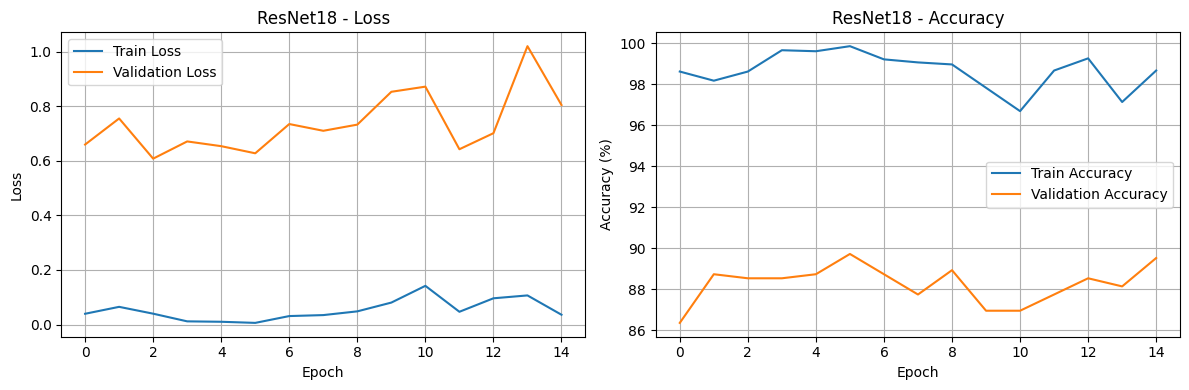


MÉTRICAS DETALLADAS - ResNet18
Accuracy General: 0.8953 (89.53%)
Macro Precision: 0.8824
Macro Recall: 0.8806
Macro F1-Score: 0.8809

                     Métricas por Clase                     
------------------------------------------------------------
Clase        Precision  Recall     F1-Score   Support   
------------------------------------------------------------
cardboard    0.9114     0.9351     0.9231     77        
glass        0.9474     0.8571     0.9000     105       
metal        0.8370     0.8953     0.8652     86        
paper        0.9083     0.9397     0.9237     116       
plastic      0.9091     0.8989     0.9040     89        
trash        0.7812     0.7576     0.7692     33        
------------------------------------------------------------


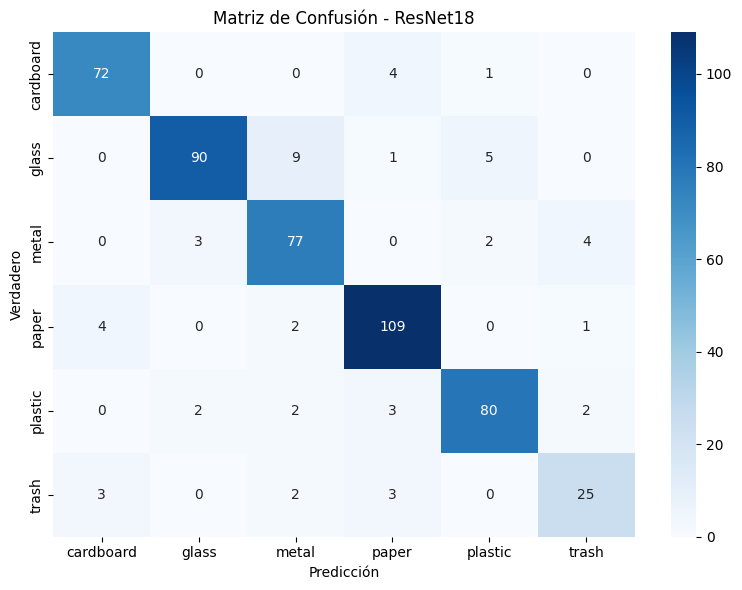

In [ ]:
# Configurar optimizador para ResNet18 con diferentes learning rates
other_params = [p for name, p in model_resnet.named_parameters() if 'fc' not in name]
fc_params = model_resnet.fc.parameters()

# Configurar optimizador para ResNet18 with different learning rates
optimizer_resnet = optim.Adam([
    {'params': other_params, 'lr': LEARNING_RATE * 0.1},
    {'params': fc_params, 'lr': LEARNING_RATE}
])
# Entrenar ResNet18
model_resnet, history_resnet = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer_resnet,
    NUM_EPOCHS, "ResNet18"
)

# Evaluar ResNet18
metrics_resnet = evaluate_model(model_resnet, val_loader, CLASSES)

# Guardar resultados
models_results['ResNet18'] = {
    'model': model_resnet,
    'metrics': metrics_resnet,
    'history': history_resnet
}

# Mostrar resultados
plot_training_history(history_resnet, "ResNet18")
print_detailed_metrics(metrics_resnet, CLASSES, "ResNet18")
plot_confusion_matrix(metrics_resnet['confusion_matrix'], CLASSES, "ResNet18")

# Comparación de Modelos y Selección del Mejor


                             COMPARACIÓN DE MODELOS                             
     Modelo Accuracy Macro Precision Macro Recall Macro F1-Score Best Val Acc
  SimpleCNN   0.6364          0.6152       0.6342         0.6193       68.38%
MobileNetV2   0.8103          0.7910       0.7962         0.7840       90.51%
   ResNet18   0.8953          0.8824       0.8806         0.8809       89.72%

 MEJOR MODELO: ResNet18
   Macro F1-Score: 0.8809


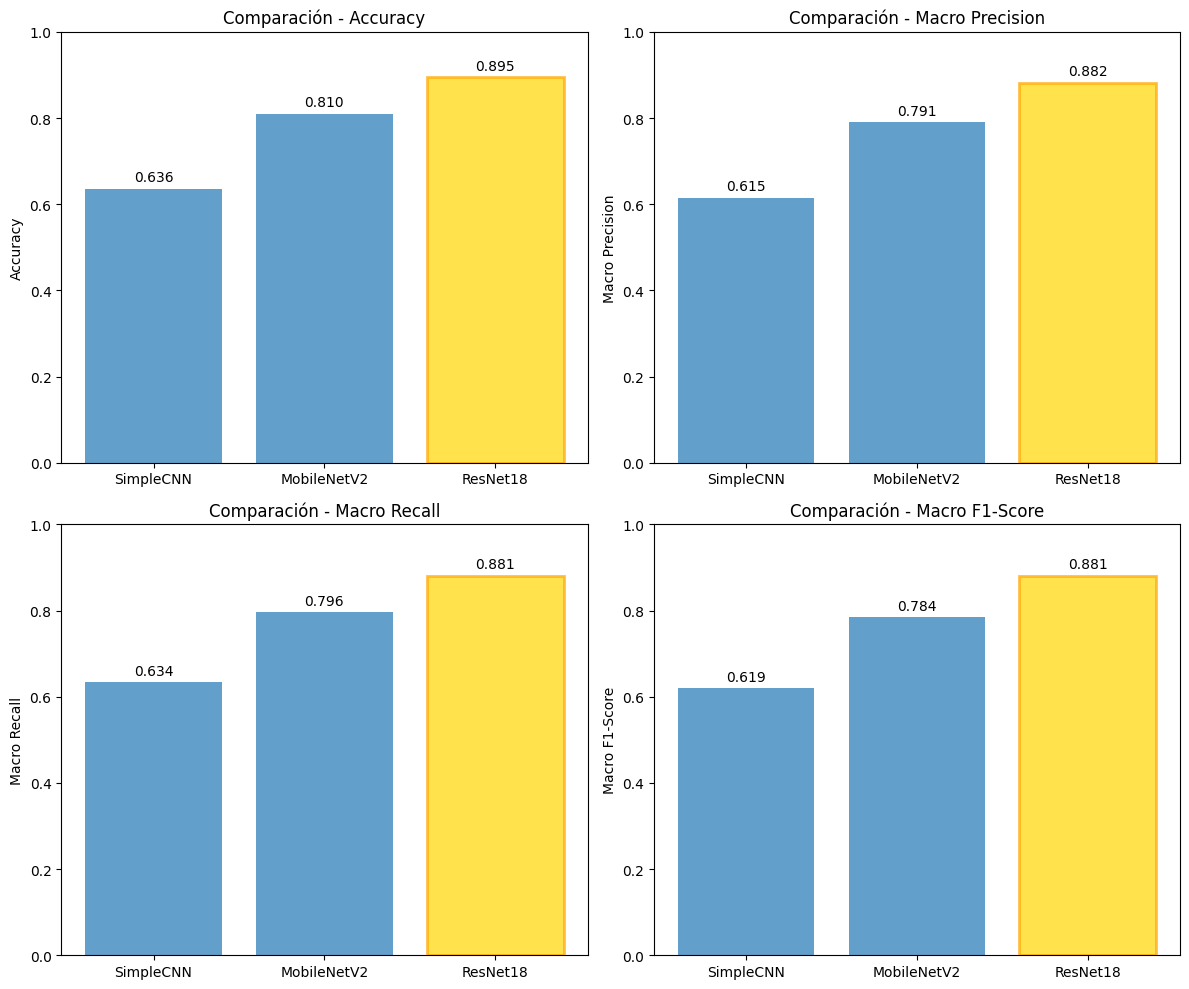

In [ ]:
def compare_models(models_results):
    """Comparar todos los modelos entrenados"""

    print(f"\n{'='*80}")
    print(f"{'COMPARACIÓN DE MODELOS':^80}")
    print(f"{'='*80}")

    comparison_data = []

    for model_name, results in models_results.items():
        metrics = results['metrics']
        history = results['history']

        comparison_data.append({
            'Modelo': model_name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Macro Precision': f"{metrics['macro_precision']:.4f}",
            'Macro Recall': f"{metrics['macro_recall']:.4f}",
            'Macro F1-Score': f"{metrics['macro_f1']:.4f}",
            'Best Val Acc': f"{history['best_val_acc']:.2f}%"
        })

    # Crear DataFrame para comparación
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

    # Determinar el mejor modelo basado en Macro F1-Score
    best_model_name = max(models_results.keys(),
                         key=lambda x: models_results[x]['metrics']['macro_f1'])

    print(f"\n MEJOR MODELO: {best_model_name}")
    print(f"   Macro F1-Score: {models_results[best_model_name]['metrics']['macro_f1']:.4f}")

    return best_model_name, df_comparison

# Comparar modelos
best_model_name, comparison_df = compare_models(models_results)


# Gráfico de comparación de métricas principales
def plot_models_comparison(models_results):
    """Graficar comparación entre modelos"""

    model_names = list(models_results.keys())
    metrics_names = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1']
    metrics_labels = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, (metric, label) in enumerate(zip(metrics_names, metrics_labels)):
        values = [models_results[name]['metrics'][metric] for name in model_names]

        bars = axes[i].bar(model_names, values, alpha=0.7)
        axes[i].set_title(f'Comparación - {label}')
        axes[i].set_ylabel(label)
        axes[i].set_ylim(0, 1)

        # Añadir valores en las barras
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')

        # Resaltar el mejor modelo
        best_idx = values.index(max(values))
        bars[best_idx].set_color('gold')
        bars[best_idx].set_edgecolor('orange')
        bars[best_idx].set_linewidth(2)

    plt.tight_layout()
    plt.show()

plot_models_comparison(models_results)

# Guardado del Mejor Modelo

In [ ]:
# Crear directorio prod si no existe
os.makedirs('/content/drive/MyDrive/LABS REDES NEURONALES/Trabajo practico integrador/prod', exist_ok=True)

# Guardar el mejor modelo
best_model = models_results[best_model_name]['model']
model_path = '/content/drive/MyDrive/GreenAI/prod/modelo.pth'

torch.save(best_model.state_dict(), model_path)
print(f"Mejor modelo ({best_model_name}) guardado en: {model_path}")

# Guardar también información adicional del modelo
model_info = {
    'model_name': best_model_name,
    'model_architecture': str(best_model),
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'metrics': models_results[best_model_name]['metrics'],
    'img_size': IMG_SIZE,
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    }
}

# Resumen Final

print(f"\n{'='*80}")
print(f"{'RESUMEN FINAL DEL ENTRENAMIENTO':^80}")
print(f"{'='*80}")

print(f"\nDataset utilizado:")
print(f"   • Total de imágenes: {dataset_size}")
print(f"   • Imágenes de entrenamiento: {len(train_dataset)}")
print(f"   • Imágenes de validación: {len(val_dataset)}")
print(f"   • Clases: {', '.join(CLASSES)}")

print(f"\n Modelos entrenados:")
for i, model_name in enumerate(models_results.keys(), 1):
    print(f"   {i}. {model_name}")

print(f"\n Mejor modelo seleccionado: {best_model_name}")
best_metrics = models_results[best_model_name]['metrics']
print(f"   • Accuracy: {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)")
print(f"   • Macro F1-Score: {best_metrics['macro_f1']:.4f}")
print(f"   • Guardado en: ../prod/modelo.pth")

print(f"\n Entrenamiento completado exitosamente!")
print(f"{'='*80}")

# %%
# Función para cargar el modelo entrenado (para futuro uso)
def load_trained_model(model_path, model_name, num_classes=NUM_CLASSES):
    """Función para cargar el modelo entrenado guardado"""

    if model_name == 'SimpleCNN':
        model = SimpleCNN(num_classes=num_classes)
    elif model_name == 'MobileNetV2':
        model = create_mobilenet_model(num_classes=num_classes, pretrained=False)
    elif model_name == 'ResNet18':
        model = create_resnet_model(num_classes=num_classes, pretrained=False)
    else:
        raise ValueError(f"Modelo no reconocido: {model_name}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model

print(f"\n Para cargar el modelo entrenado en el futuro, usar:")
print(f"   model = load_trained_model('../prod/modelo.pth', '{best_model_name}')")

Mejor modelo (ResNet18) guardado en: /content/drive/MyDrive/GreenAI/prod/modelo.pth

                        RESUMEN FINAL DEL ENTRENAMIENTO                         

Dataset utilizado:
   • Total de imágenes: 2527
   • Imágenes de entrenamiento: 2021
   • Imágenes de validación: 506
   • Clases: cardboard, glass, metal, paper, plastic, trash

 Modelos entrenados:
   1. SimpleCNN
   2. MobileNetV2
   3. ResNet18

 Mejor modelo seleccionado: ResNet18
   • Accuracy: 0.8953 (89.53%)
   • Macro F1-Score: 0.8809
   • Guardado en: ../prod/modelo.pth

 Entrenamiento completado exitosamente!

 Para cargar el modelo entrenado en el futuro, usar:
   model = load_trained_model('../prod/modelo.pth', 'ResNet18')
